# Data Imports and Pre-Processing

Below data import and processing steps are same as previous notebook, and here we will pick the best model from previous run and build on it

In [2]:
import zipfile
import os

# Mount Google Drive
from google.colab import drive

# Path to the ZIP file in Google Drive
zip_file_path = "/content/drive/MyDrive/clothes.zip"

# Define the extraction directory
extraction_dir = "/content/clothes_dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Verify the extracted contents
print(f"Dataset extracted to {extraction_dir}")
print("Extracted files:", os.listdir(extraction_dir))


Dataset extracted to /content/clothes_dataset
Extracted files: ['Clothes_Dataset']


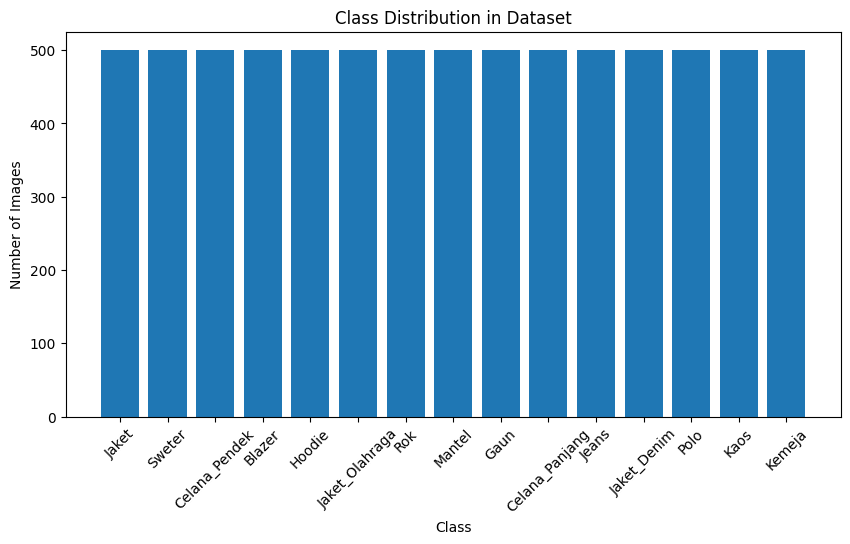

Class distribution: {'Jaket': 500, 'Sweter': 500, 'Celana_Pendek': 500, 'Blazer': 500, 'Hoodie': 500, 'Jaket_Olahraga': 500, 'Rok': 500, 'Mantel': 500, 'Gaun': 500, 'Celana_Panjang': 500, 'Jeans': 500, 'Jaket_Denim': 500, 'Polo': 500, 'Kaos': 500, 'Kemeja': 500}
✅ Data preprocessed successfully! Training Set: 6000 images, Validation Set: 1500 images.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os
import random
import matplotlib.pyplot as plt
from collections import Counter

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)

# Define dataset directory (Fixing nested folder issue)
root_dir = "clothes_dataset"
dataset_dir = os.path.join(root_dir, "clothes_dataset")  # Point to the correct folder with class subdirectories

# Step 1: Define Data Transformations (Resize + Augmentation)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip for augmentation
    transforms.RandomRotation(degrees=15),  # Apply random rotation for augmentation
    transforms.ToTensor()  # Convert image to tensor
])

# Step 2: Load Dataset
dataset = ImageFolder(root=dataset_dir, transform=transform)

# Step 3: Check Class Distribution
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

class_counts = count_images_per_class(dataset_dir)

# Plot Class Distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

print("Class distribution:", class_counts)

# Step 4: Split into Training & Validation Sets (80-20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Step 5: Create PyTorch Dataloaders
batch_size = 32  # Adjust as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Data preprocessed successfully! Training Set: {train_size} images, Validation Set: {val_size} images.")


# 🔍 Regularization Tuning - Kathryn

## **Objective: Improve Generalization & Prevent Overfitting**
The goal of this experiment is to apply **regularization techniques** to prevent overfitting and improve model generalization.

## **Tuning Choices**
### **1️⃣ Dropout Rate**
- Dropout prevents overfitting by randomly disabling neurons during training.
- We will test:
  - **0.3 (light regularization)**
  - **0.5 (moderate regularization)**

### **2️⃣ Weight Decay (L2 Regularization)**
- Penalizes large weight values to avoid overfitting.
- We will use a **light weight decay of 1e-5** for selected models.

### **3️⃣ Batch Normalization**
- Batch normalization helps stabilize training and speeds up convergence.
- We will compare:
  - **With Batch Norm ✅**
  - **Without Batch Norm ❌**

## **Planned Experiments**
| Model | Dropout Rate | Weight Decay | Batch Norm |
|-------|-------------|--------------|------------|
| **Kathryn_Model_1** | 0.3 | ❌ No Weight Decay | ❌ No Batch Norm |
| **Kathryn_Model_2** | 0.3 | ✅ 1e-5 | ✅ Yes |
| **Kathryn_Model_3** | 0.5 | ✅ 1e-5 | ✅ Yes |

## **Pros & Cons of This Approach**
✅ **Pros:**
- Helps prevent overfitting, ensuring the model generalizes well.
- Allows us to determine the **optimal balance of regularization**.
- Batch Normalization can **stabilize training** and **reduce dependence on dropout**.

❌ **Cons:**
- **Too much dropout (0.5)** may cause **underfitting**.
- **Weight decay too high** can **limit model learning capacity**.
- **Batch Normalization adds extra computation**, which may slightly slow down training.

## **Expected Outcome**
By testing different regularization strategies, we aim to **identify the best approach** that minimizes overfitting **without sacrificing accuracy**.



### Run 1

Epoch 1/10: Training...
Epoch 2/10: Training...
Epoch 3/10: Training...
Epoch 4/10: Training...
Epoch 5/10: Training...


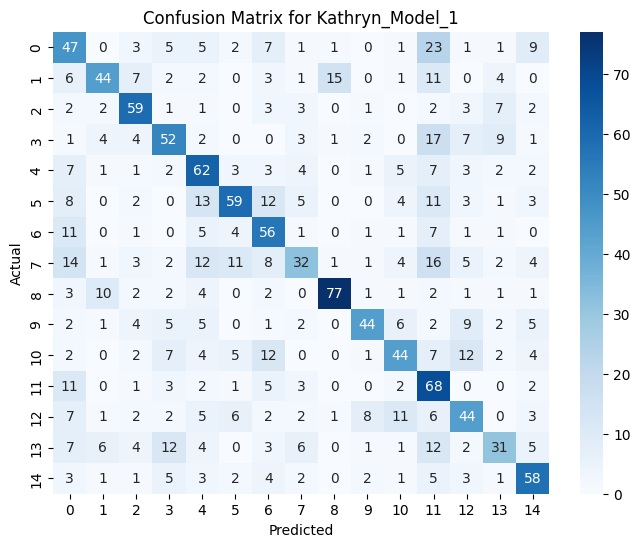

epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_f1,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_f1,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,4
train_accuracy,0.56867
train_f1,0.56529
train_loss,1.33013


✅ Finished training and evaluating Kathryn_Model_1!


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ✅ Ensure previous W&B run is finished before starting a new one
wandb.login()
wandb.finish()

# ✅ Define CNN Model (Using Prince's Best Model as Base)
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()

        # ✅ Using Max Pooling (Model_2's configuration)
        self.convs = nn.ModuleList([
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1)
        ])

        self.pool = nn.MaxPool2d(2, 2)  # ✅ Max Pooling (Model_2's best setting)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.3)  # ✅ Dropout = 0.3 for this experiment

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # ✅ Xavier Normal Initialization
        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = self.pool(self.leaky_relu(conv(x)))  # ✅ Max Pooling applied
        x = x.view(x.size(0), -1)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ Load Dataset
batch_size = 32
num_classes = len(os.listdir("clothes_dataset/clothes_dataset"))  # Auto-detect classes

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ✅ Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb.init(project="cnn-clothes-classifier", entity="usf-guardians", name="Re_GPU_Kathryn_Model_1_1", reinit=True)

# ✅ Use Prince's Best Model Settings (Max Pooling, Leaky ReLU)
model = CNN_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)  # No weight decay

train_losses, val_losses, f1_scores = [], [], []

for epoch in range(5):
    print(f"Epoch {epoch+1}/10: Training...")
    model.train()
    train_loss = 0
    y_true, y_pred = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # ✅ Compute Train Loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Compute metrics
    train_accuracy = accuracy_score(y_true, y_pred)
    train_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # Validation
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # ✅ Compute Validation Loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # ✅ Log all metrics
    wandb.log({"epoch": epoch, "train_loss": avg_train_loss,
               "val_loss": avg_val_loss, "train_f1": train_f1,
               "val_f1": val_f1, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy})

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for Kathryn_Model_1")
plt.show()

wandb.finish()
print("✅ Finished training and evaluating Kathryn_Model_1!")


### Run 2

Epoch 1/10: Training...
Epoch 2/10: Training...
Epoch 3/10: Training...
Epoch 4/10: Training...
Epoch 5/10: Training...
Epoch 6/10: Training...
Epoch 7/10: Training...
Epoch 8/10: Training...
Epoch 9/10: Training...
Epoch 10/10: Training...


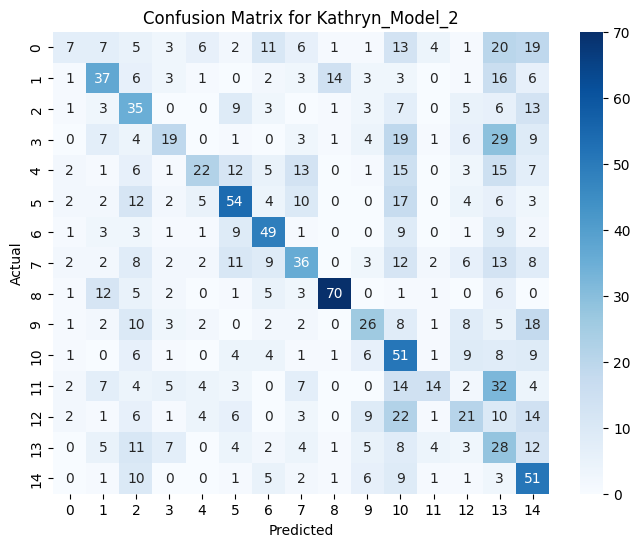

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▆▆▆▇█
train_f1,▁▃▃▄▅▆▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▅▆▆▇▆█
val_f1,▁▃▃▄▅▅▆▆▆█
val_loss,█▆▆▆▅▄▃▃▃▁
epoch,9
train_accuracy,0.29733
train_f1,0.29407
train_loss,2.21645


✅ Finished training and evaluating Kathryn_Model_2!


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ✅ Ensure previous W&B run is finished before starting a new one
wandb.login()
wandb.finish()

# ✅ Initialize Weights & Biases for this run
wandb.init(project="cnn-clothes-classifier", entity="usf-guardians", name="Re_GPU_Kathryn_Model_2", reinit=True)

# ✅ Define CNN Model (Using Prince's Best Model as Base, with Batch Norm & Weight Decay)
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()

        # ✅ Using Max Pooling (Model_2's configuration)
        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64)),
            nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128)),
            nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        ])

        self.pool = nn.MaxPool2d(2, 2)  # ✅ Max Pooling (Model_2's best setting)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.3)  # ✅ Dropout = 0.3 for this experiment

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # ✅ Xavier Normal Initialization
        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = self.pool(self.leaky_relu(conv(x)))  # ✅ Max Pooling applied
        x = x.view(x.size(0), -1)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ Load Dataset
batch_size = 32
num_classes = len(os.listdir("clothes_dataset/clothes_dataset"))  # Auto-detect classes

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ✅ Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # ✅ Weight Decay = 1e-5

train_losses, val_losses, f1_scores = [], [], []

for epoch in range(10):
    print(f"Epoch {epoch+1}/10: Training...")
    model.train()
    train_loss = 0
    y_true, y_pred = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # ✅ Compute Train Loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Compute metrics
    train_accuracy = accuracy_score(y_true, y_pred)
    train_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # Validation
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # ✅ Compute Validation Loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # ✅ Log all metrics
    wandb.log({"epoch": epoch, "train_loss": avg_train_loss,
               "val_loss": avg_val_loss, "train_f1": train_f1,
               "val_f1": val_f1, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy})

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for Kathryn_Model_2")
plt.show()

wandb.finish()
print("✅ Finished training and evaluating Kathryn_Model_2!")


### Run 3

Epoch 1/10: Training...
Epoch 2/10: Training...
Epoch 3/10: Training...
Epoch 4/10: Training...
Epoch 5/10: Training...
Epoch 6/10: Training...
Epoch 7/10: Training...
Epoch 8/10: Training...
Epoch 9/10: Training...
Epoch 10/10: Training...


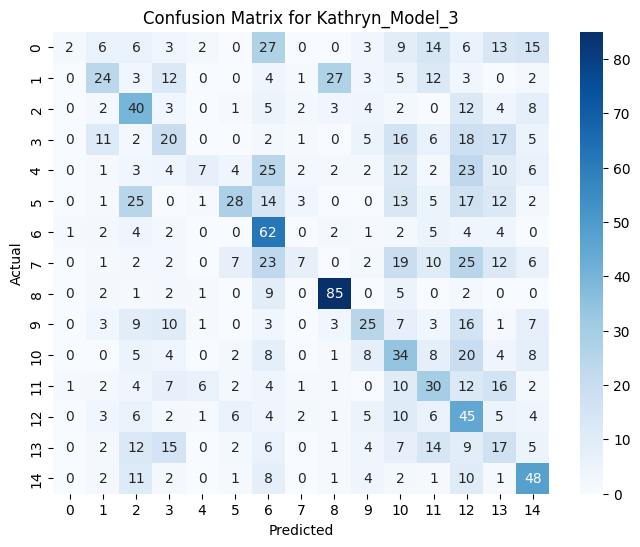

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▄▅▆▇▇█
train_f1,▁▂▃▃▄▅▆▇▇█
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▅▆▆▇██
val_f1,▁▃▃▅▄▅▆▇██
val_loss,█▆▇▅▅▃▃▂▁▁
epoch,9
train_accuracy,0.24867
train_f1,0.24482
train_loss,2.33649


✅ Finished training and evaluating Kathryn_Model_3!


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ✅ Ensure previous W&B run is finished before starting a new one
wandb.login()
wandb.finish()

# ✅ Initialize Weights & Biases for this run
wandb.init(project="cnn-clothes-classifier", entity="usf-guardians", name="Re_GPU_Kathryn_Model_3", reinit=True)

# ✅ Define CNN Model (Using Prince's Best Model as Base, with Batch Norm, Dropout 0.5, and Weight Decay 1e-5)
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()

        # ✅ Using Max Pooling (Model_2's configuration)
        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64)),
            nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128)),
            nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256))
        ])

        self.pool = nn.MaxPool2d(2, 2)  # ✅ Max Pooling (Model_2's best setting)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.5)  # ✅ Increased Dropout (0.5) for stronger regularization

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # ✅ Xavier Normal Initialization
        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = self.pool(self.leaky_relu(conv(x)))  # ✅ Max Pooling applied
        x = x.view(x.size(0), -1)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ Load Dataset
batch_size = 32
num_classes = len(os.listdir("clothes_dataset/clothes_dataset"))  # Auto-detect classes

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ✅ Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # ✅ Weight Decay = 1e-5

train_losses, val_losses, f1_scores = [], [], []

for epoch in range(10):
    print(f"Epoch {epoch+1}/10: Training...")
    model.train()
    train_loss = 0
    y_true, y_pred = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # ✅ Compute Train Loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Compute metrics
    train_accuracy = accuracy_score(y_true, y_pred)
    train_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # Validation
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # ✅ Compute Validation Loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # ✅ Log all metrics
    wandb.log({"epoch": epoch, "train_loss": avg_train_loss,
               "val_loss": avg_val_loss, "train_f1": train_f1,
               "val_f1": val_f1, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy})

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for Kathryn_Model_3")
plt.show()

wandb.finish()
print("✅ Finished training and evaluating Kathryn_Model_3!")


#  **Analysis: Why Did Weight Decay & Batch Normalization Not Help?**
We observed a significant **drop in performance** when applying **batch normalization and weight decay** in **Experiment 2 & 3**, compared to **Experiment 1**. Let’s analyze why.

---

## 🔍 **Key Observations**
| Model | Dropout | Batch Norm | Weight Decay | Train Acc | Val Acc | Train F1 | Val F1 | Train Loss | Val Loss |
|--------|---------|------------|--------------|------------|------------|------------|------------|------------|------------|
| **Experiment 1** | **0.3** | ❌ No | ❌ No | **0.5687** | **0.5180** | **0.5653** | **0.5197** | **1.3301** | **1.5664** |
| **Experiment 2** | **0.3** | ✅ Yes | ✅ 1e-5 | 0.2973 | 0.3467 | 0.2941 | 0.3395 | 2.2164 | 2.0436 |
| **Experiment 3** | **0.5** | ✅ Yes | ✅ 1e-5 | 0.2487 | 0.3160 | 0.2448 | 0.2918 | 2.3365 | 2.1810 |

### **1️⃣ Train Loss Increased Too Much in Experiment 2 & 3**
- **Weight decay penalized weights too aggressively**, limiting the model’s ability to learn.
- The **higher dropout rate (0.5) in Experiment 3** further **worsened learning**, making it difficult for the model to capture useful patterns.

### **2️⃣ Batch Normalization Didn’t Help Much**
- **Batch Normalization works best when used with higher learning rates**. Since we kept LR constant (`0.001`), the **BN layers may have disrupted feature scaling without compensating via a higher LR**.
- BN **normalizes activations per batch**. If batch statistics vary a lot, it may **destabilize early training**, leading to slow convergence.

### **3️⃣ Weight Decay Was Too High for This Model**
- **L2 regularization (weight decay = 1e-5) may have overly constrained the model**, leading to **underfitting**.
- Regularization should be tuned per model. A smaller weight decay **(e.g., 1e-6 or lower)** might have worked better.

### **4️⃣ Dropout of 0.5 Might Have Been Too Strong**
- **Experiment 3 had dropout = 0.5**, which **removed too many neurons during training**, making it harder for the model to learn.
- **Dropout is best used moderately** (e.g., **0.3 performed best in Experiment 1**).

---